# Homework 2 - Berkeley STAT 157

Handout 1/29/2019, due 2/5/2019 by 4pm in Git by committing to your repository.

In [1]:
from mxnet import nd, autograd, gluon

# 1. Multinomial Sampling

Implement a sampler from a discrete distribution from scratch, mimicking the function `mxnet.ndarray.random.multinomial`. Its arguments should be a vector of probabilities $p$. You can assume that the probabilities are normalized, i.e. tha they sum up to $1$. Make the call signature as follows:

```
samples = sampler(probs, shape) 

probs   : An ndarray vector of size n of nonnegative numbers summing up to 1
shape   : A list of dimensions for the output
samples : Samples from probs with shape matching shape
```

Hints:

1. Use `mxnet.ndarray.random.uniform` to get a sample from $U[0,1]$.
1. You can simplify things for `probs` by computing the cumulative sum over `probs`.

In [2]:
nd.random.multinomial(nd.array([0.3, 0.3, 0.4]))


[1]
<NDArray 1 @cpu(0)>

In [40]:
def sampler(probs, shape):
    ## Add your codes here
    
    cumulative_probs = nd.zeros_like(probs)
    for i in range(probs.size):
        cumulative_probs[i] = nd.sum(probs[:i+1])    
    vals = []
    for i in range((int)(nd.prod(nd.array(shape)).asscalar())):
        rand = nd.random.uniform()
        for j, k in enumerate(cumulative_probs):
            if rand <= k:
                vals.append(j)
    
    return nd.array(vals).reshape(shape)

# a simple test
sampler(nd.array([0.2, 0.3, 0.5]), (2,3))


[[ 1.  2.  1.]
 [ 2.  2.  0.]]
<NDArray 2x3 @cpu(0)>

# 2. Central Limit Theorem

Let's explore the Central Limit Theorem when applied to text processing. 

* Download [https://www.gutenberg.org/ebooks/84](https://www.gutenberg.org/files/84/84-0.txt) from Project Gutenberg 
* Remove punctuation, uppercase / lowercase, and split the text up into individual tokens (words).
* For the words `a`, `and`, `the`, `i`, `is` compute their respective counts as the book progresses, i.e. 
    $$n_\mathrm{the}[i] = \sum_{j = 1}^i \{w_j = \mathrm{the}\}$$
* Plot the proportions $n_\mathrm{word}[i] / i$ over the document in one plot.
* Find an envelope of the shape $O(1/\sqrt{i})$ for each of these five words.
* Why can we **not** apply the Central Limit Theorem directly? 
* How would we have to change the text for it to apply? 
* Why does it still work quite well?

In [4]:
filename = gluon.utils.download('https://www.gutenberg.org/files/84/84-0.txt')
with open(filename) as f:
    book = f.read()
print(type(book))
import string
words = list(map(lambda x: x.strip(string.punctuation).lower(), book.split()))
counter = {'the':0, 'a':0, 'and':0, 'i':0, 'is':0}
proportions = nd.zeros((5, len(words)))
for i, word in enumerate(words):
    if word in counter:
        counter[word] += 1
    proportions[:, i] = nd.array(list(counter.values())) / i
print(proportions.shape)

## Add your codes here

<class 'str'>
(5, 78098)


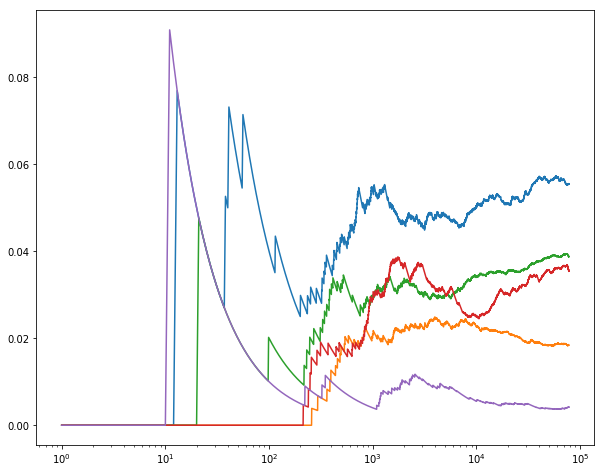

In [38]:
import matplotlib.pyplot as plt

props = proportions.asnumpy()
plt.figure(figsize=(10, 8))
plt.xscale("log")
for i in range(5):
    plt.plot(range(78098), props[i, :])

In [47]:
import numpy as np
word_arr = np.array(words)
[sum(word_arr == word) for word in counter.keys()]

[4329, 1439, 3028, 2766, 330]

## 3. Denominator-layout notation

We used the numerator-layout notation for matrix calculus in class, now let's examine the denominator-layout notation.

Given $x, y\in\mathbb R$, $\mathbf x\in\mathbb R^n$ and $\mathbf y \in \mathbb R^m$, we have

$$
\frac{\partial y}{\partial \mathbf{x}}=\begin{bmatrix}
\frac{\partial y}{\partial x_1}\\
\frac{\partial y}{\partial x_2}\\
\vdots\\
\frac{\partial y}{\partial x_n}
\end{bmatrix},\quad 
\frac{\partial \mathbf y}{\partial {x}}=\begin{bmatrix}
\frac{\partial y_1}{\partial x}, 
\frac{\partial y_2}{\partial x}, 
\ldots,
\frac{\partial y_m}{\partial x}
\end{bmatrix}
$$

and 

$$
\frac{\partial \mathbf y}{\partial \mathbf{x}}
=\begin{bmatrix}
\frac{\partial \mathbf y}{\partial {x_1}}\\
\frac{\partial \mathbf y}{\partial {x_2}}\\
\vdots\\
\frac{\partial \mathbf y}{\partial {x_3}}\\
\end{bmatrix}
=\begin{bmatrix}
\frac{\partial y_1}{\partial x_1}, 
\frac{\partial y_2}{\partial x_1},
\ldots,
\frac{\partial y_m}{\partial x_1}
\\ 
\frac{\partial y_1}{\partial x_2},
\frac{\partial y_2}{\partial x_2},
\ldots,
\frac{\partial y_m}{\partial x_2}\\ 
\vdots\\
\frac{\partial y_1}{\partial x_n},
\frac{\partial y_2}{\partial x_n},
\ldots,
\frac{\partial y_m}{\partial x_n}
\end{bmatrix}
$$

Questions: 

1. Assume $\mathbf  y = f(\mathbf u)$ and $\mathbf u = g(\mathbf x)$, write down the chain rule for $\frac {\partial\mathbf  y}{\partial\mathbf x}$
2. Given $\mathbf X \in \mathbb R^{m\times n},\ \mathbf w \in \mathbb R^n, \ \mathbf y \in \mathbb R^m$, assume $z = \| \mathbf X \mathbf w - \mathbf y\|^2$, compute $\frac{\partial z}{\partial\mathbf w}$.

1. $\frac {\partial\mathbf  y}{\partial\mathbf x} = \frac {\partial\mathbf  y}{\partial\mathbf u} \frac {\partial\mathbf  u}{\partial\mathbf x}$

2. $z = (Xw - y)^T(Xw - y)$

$z = w^TX^TXw - 2y^TXw + y^Ty$

$\frac{\partial z}{\partial\mathbf w} = 2X^TXw - 2y^TX$

## 4. Numerical Precision

Given scalars `x` and `y`, implement the following `log_exp` function such that it returns a numerically stable version of 
$$-\log\left(\frac{e^x}{e^x+e^y}\right)$$

In [5]:
def log_exp(x, y):
    ## add your solution here
    return -nd.log(nd.exp(x) / (nd.exp(x) + nd.exp(y)))

Test your codes with normal inputs:

In [6]:
x, y = nd.array([2]), nd.array([3])
z = log_exp(x, y)
z


[ 1.31326175]
<NDArray 1 @cpu(0)>

Now implement a function to compute $\partial z/\partial x$ and $\partial z/\partial y$ with `autograd`

In [27]:
def grad(forward_func, x, y): 
    x.attach_grad()
    y.attach_grad()
    with autograd.record():
        z = forward_func(x, y)
    z.backward()
    print('x.grad =', x.grad)
    print('y.grad =', y.grad)

Test your codes, it should print the results nicely. 

In [28]:
grad(log_exp, x, y)

x.grad = 
[-0.7310586]
<NDArray 1 @cpu(0)>
y.grad = 
[ 0.7310586]
<NDArray 1 @cpu(0)>


But now let's try some "hard" inputs

In [29]:
x, y = nd.array([50]), nd.array([100])
grad(log_exp, x, y)

x.grad = 
[ nan]
<NDArray 1 @cpu(0)>
y.grad = 
[ nan]
<NDArray 1 @cpu(0)>


Does your code return correct results? If not, try to understand the reason. (Hint, evaluate `exp(100)`). Now develop a new function `stable_log_exp` that is identical to `log_exp` in math, but returns a more numerical stable result.

In [31]:
def stable_log_exp(x, y):
    xs = x.asscalar()
    ys = y.asscalar()
    if xs < ys:
        denom = x + nd.log(1 + nd.exp(y - x))
    else:
        denom = y + nd.log(1 + nd.exp(x - y))
    return -x + denom

grad(stable_log_exp, x, y)

x.grad = 
[-1.]
<NDArray 1 @cpu(0)>
y.grad = 
[ 1.]
<NDArray 1 @cpu(0)>
